# Label the training dataset

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
pd.set_option('max_colwidth', 140)

In [2]:
dataset = "../train.json"
df = pd.read_json(dataset,lines=True)

In [3]:
# Peel out count of helpful votes into its own column
df['helpful_votes'] = df.apply(lambda x: x.helpful[0],axis=1)
# To avoid confusion later, drop the 'helpful' column at this point
df.drop('helpful', axis = 1, inplace=True)
# Convert reviewTime to datetime type info we can work with
df.reviewTime = pd.to_datetime(df.reviewTime,infer_datetime_format=True)

In [4]:
print("Our dataset initially contains {} reviews".format(df.shape[0]))

Our dataset initially contains 3804066 reviews


In [5]:
# Our dataset snapshot has as its maximum review date 2014-07-23
snapshotted_string = "20140723"
snapshotted = datetime.datetime.strptime(snapshotted_string, '%Y%m%d')

# We will DROP reviews less than one year old
# They may not have accumulated enough evidence to support being helpful or not
ourcutoff = snapshotted - datetime.timedelta(days=365)
df = df[df.reviewTime < ourcutoff]
print("After removing reviews less than one year old, our dataset contains {} reviews".format(df.shape[0]))

After removing reviews less than one year old, our dataset contains 2884665 reviews


In [6]:
# Here we store the age of each review in days
df['review_age_days'] = df.apply(lambda x: (snapshotted - x.reviewTime).days,axis = 1)

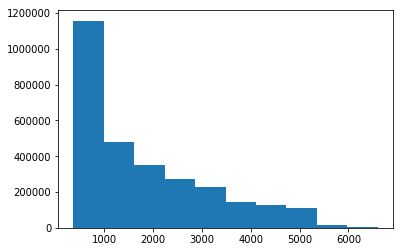

In [7]:
days_old_hist = plt.hist(df['review_age_days'])

In [8]:
# We create the annual HVAR score
df['annual_HVAR'] = df.apply(lambda x: 365*x.helpful_votes/x.review_age_days, axis = 1)

In [9]:
# Now we group by the book id
# And aggregate by count of unique reviews for the given book
# (We count using unixReviewTime as a proxy for uniqueness because there's no review ID provided)
# We also aggregate the HVAR within groups by its standard deviation
# As we cannot retrieve a signal with respect to helpfulness if reviews don't have variance 
by_book = df.groupby('asin').agg({'unixReviewTime':'size','annual_HVAR': lambda x: (x.std(),x.quantile(.75))})

In [10]:
# Extract standard deviation to filter out zero-valued books later
by_book['std_HVAR'] = by_book.apply(lambda x: x.annual_HVAR[0],axis = 1)
# Extract top quartile cutoff per book
by_book['top_quartile_HVAR'] = by_book.apply(lambda x: x.annual_HVAR[1],axis = 1)
# Drop the combo column now that we have them separated
by_book.drop('annual_HVAR',axis=1,inplace=True)
# Rename for clarity when filtering by this column later
by_book.rename(columns={"unixReviewTime": "book_num_reviews"}, inplace=True)

In [11]:
by_book.columns

Index(['book_num_reviews', 'std_HVAR', 'top_quartile_HVAR'], dtype='object')

In [12]:
# Now print out resulting size of review dataset
print("There are {} unique books in this dataset".format(by_book.shape[0]))
# by_book.rename(columns={"unixReviewTime": "book_num_reviews","annual_HVAR":"std_HVAR"}, inplace=True)
print("{} reviews will remain after final filters applied".format(by_book[(by_book.book_num_reviews >=4)\
    & (by_book.std_HVAR != 0)].book_num_reviews.sum()))

There are 301794 unique books in this dataset
2659724 reviews will remain after final filters applied


In [19]:
by_book.head()

,book_num_reviews,std_HVAR,top_quartile_HVAR
asin,,,
000100039X,86,2.930287,0.842702
0001055178,12,0.332911,0.465856
0001473123,3,1.149615,1.526551
0001473727,3,0.069478,0.756506
0001473905,2,0.311713,0.710632


In [20]:
# Save this off because will use the cutoff to label the dev and test sets
by_book.to_csv('../book_cutoffs.csv',index=True)

In [13]:
# We join the review_counts and std_HVAR plus cutoff values back onto the original dataframe
df = df.join(by_book,on='asin')
# And we filter down that original dataframe to contain only the reviews we'll be labeling
df = df[(df.book_num_reviews >=4) & (~df.std_HVAR.isnull()) & (df.std_HVAR > 0)]

In [14]:
# And now we label the reviews that are in the top quartile as 'most_helpful' = 1 (otherwise 0)
df['most_helpful'] = df.apply(lambda x: int(x.annual_HVAR > x.top_quartile_HVAR),axis = 1)

In [15]:
df.most_helpful.sum()/df.shape[0]
# Yep, is 25.3%

0.25512233600178064

In [113]:
df.columns

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'helpful_votes',
       'review_age_days', 'annual_HVAR', 'book_num_reviews', 'std_HVAR',
       'top_quartile_HVAR', 'most_helpful'],
      dtype='object')

In [21]:
df[df.most_helpful == 1].head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR,most_helpful
6,000100039X,5,I first read The Prophet by Kahlil Gibran over 30 years ago and have read it many times since. Gibran's messages are timeless and have a...,2012-03-12,AF7CSSGV93RXN,"A. William Benitez ""A. William Benitez""",A Great Little Gift,1331510400,5,863,2.114716,86,2.930287,0.842702,1
8,000100039X,5,This is one of the first (literary) books I recall reading. My mother kept a collection of Gibran's works that she often read. I was cur...,2000-06-24,A1NPNGWBVD9AK3,"Bruce Kendall ""BEK""",Simple Wisdom,961804800,81,5142,5.749708,86,2.930287,0.842702,1
10,000100039X,5,The Prophet is Kahlil Gibran's best known work in the western world with over 25 million copies sold. It is said that Kahlil spent more ...,2009-10-27,A3IS4WGMFR4X65,"Colin Lewis ""WisdomNote""",The most loving book ever written,1256601600,8,1730,1.687861,86,2.930287,0.842702,1
14,000100039X,5,""" When you are joyous, look deep into your heart and you shall find it is only that which has given you sorrow is that giving you joy. W...",2009-11-29,AMRZ5G7HF7I03,"Didaskalex ""Eusebius Alexandrinus""",Gibran's Prophet-worthy Poetic Wisdom,1259452800,4,1697,0.860342,86,2.930287,0.842702,1
19,000100039X,5,"I plan to buy 3 more copies from Amazon, for my departing son & distant friends.Last night, I made a mad dash to get a copy of this book...",2011-02-27,A3A0ZK5GTHSCUV,"D. Woncisz ""LADIDAH""","QUICK AND POWERFUL ""FIRST-AID"" FOR THE BROKEN SPIRIT",1298764800,4,1242,1.175523,86,2.930287,0.842702,1


In [22]:
df[df.most_helpful == 0].head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR,most_helpful
0,000100039X,5,"This is one my must have books. It is a masterpiece of spirituality. I'll be the first to admit, its literary quality isn't much. It is ...",2003-12-11,A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",close to god,1071100800,0,3877,0.000000,86,2.930287,0.842702,0
1,000100039X,5,"A timeless classic. It is a very demanding and assuming title, but Gibran backs it up with some excellent style and content. If he had...",2002-10-07,A2XQ5LZHTD4AFT,Alaturka,A Modern Rumi,1033948800,7,4307,0.593220,86,2.930287,0.842702,0
2,000100039X,5,"I discovered The Prophet fifty years ago in college and have read it dozens of times since then. Now, in addition to my beat up hard co...",2013-01-23,A19N3FCQCLJYUA,Amazon Customer,A book everyone &#34;should&#34; read,1358899200,1,546,0.668498,86,2.930287,0.842702,0
3,000100039X,5,Can't say enough about Kahlil Gibran's work among this piece. Everybody in the whole world should read this! There is almost too much to...,2012-06-27,A3FFNE1DR5SI1W,A. Morelli,phenomenal piece of literature!,1340755200,1,756,0.482804,86,2.930287,0.842702,0
4,000100039X,5,"Cool book, I really like the quality of the production. Black clothbound with gold embossing and nice paper, looks to be cotton rag. I...",2012-02-15,ARDQ9KNB8K22N,Anwar,"""The Prophet"" is cool",1329264000,1,889,0.410574,86,2.930287,0.842702,0


In [16]:
# Write it out to a file
df.to_csv('../labeled_training_set.csv',index=False)

In [116]:
!pwd

/home/jend/fp/RealRelevantReviews


In [23]:
!ls -lah ..


total 7.9G
drwxrwxr-x  4 jend jend 4.0K Jul 13 23:56 .
drwxr-xr-x 21 jend jend 4.0K Jul  3 02:22 ..
drwxrwxr-x  2 jend jend 4.0K Jul 13 23:56 .ipynb_checkpoints
drwxrwxr-x  4 jend jend 4.0K Jul 14 00:12 RealRelevantReviews
-rw-rw-r--  1 jend jend  15M Jul 13 23:56 book_cutoffs.csv
-rw-rw-r--  1 jend jend 2.0M Jul 13 22:36 labeled_small_training_set.csv
-rw-rw-r--  1 jend jend 3.3G Jul 13 23:48 labeled_training_set.csv
-rw-rw-r--  1 jend jend 9.3M Jul  2 02:40 rowling.json
-rw-rw-r--  1 jend jend  47M Jun 22 04:41 small_train.json
-rw-rw-r--  1 jend jend 467K Jun 22 04:37 toy_train.json
-rw-rw-r--  1 jend jend 4.6G Jul  3 02:23 train.json
